In [1]:
import pandas as pd
import numpy as np
import config as c

from datetime import datetime
import itertools


import seaborn as sns
# sns.set(context='paper', style='white', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm

from functions.timeseries import data_pre_processing

In [2]:
# LOAD DATASET
powerdata = pd.read_csv(f"{c.loc_dat}/Datetime_kwh_hr_2001_3103.csv")
# Hourly dataframe trend plot
df = data_pre_processing(powerdata)

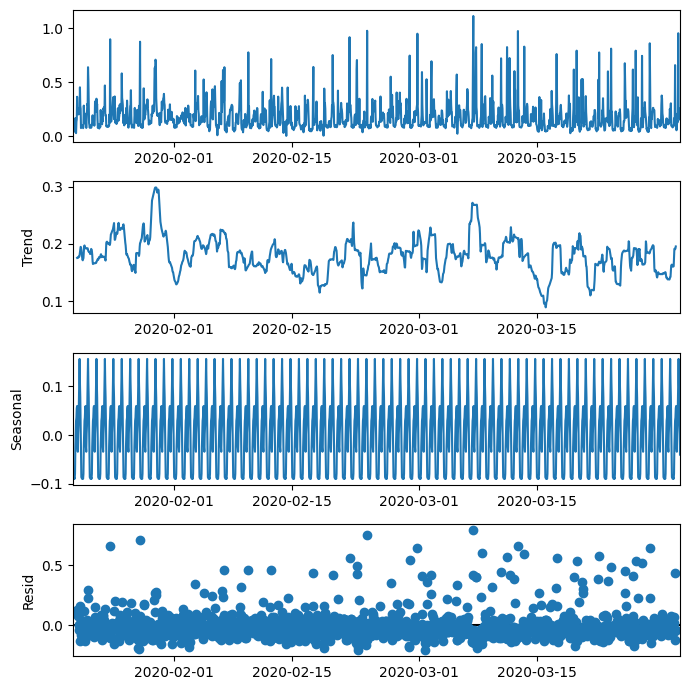

In [3]:
# Trend Identification
from pylab import rcParams
rcParams['figure.figsize'] = 7, 7
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

In [4]:
# Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

print(adf_test(df))

Results of Dickey-Fuller Test:
Test Statistic                   -5.279931
p-value                           0.000006
#Lags Used                       25.000000
Number of Observations Used    1702.000000
Critical Value (1%)              -3.434198
Critical Value (5%)              -2.863240
Critical Value (10%)             -2.567675
dtype: float64
None


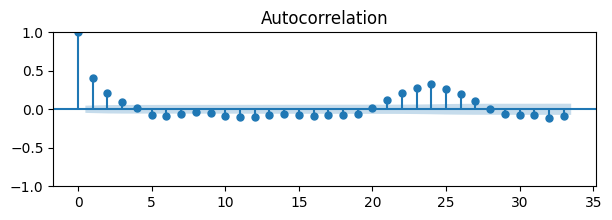

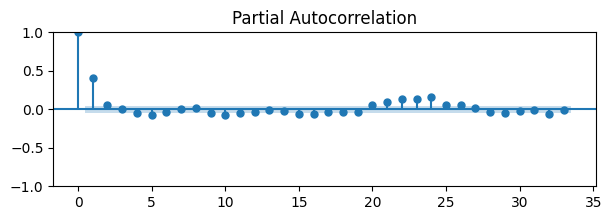

In [5]:
# ACF and PACF Plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
rcParams['figure.figsize'] = 7, 2
plot_acf(df)
plt.show()
plot_pacf(df)
plt.show()

In [6]:
# Model Creation and Grid Search
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# #PRINT EXAMPLE PARAMETERS
# print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

AIC_list = pd.DataFrame({}, columns=['param','param_seasonal','AIC'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[ param ,  param_seasonal , results.aic ]], columns=['param','param_seasonal','AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)  # DataFrame append
            del temp
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
print("Finished!!!")

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:-281.70518568156103
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:-607.0937535573257
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:-717.5385006336976
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:-2163.96743894876
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:-1073.8893670632963
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:-2169.695299306423
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:-1830.0618290343937
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:-2250.4255490277365
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:-1164.058254104743
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:-1316.3071269909592
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:-1015.0854528320071
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:-2352.723042599572
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:-1511.0780821522244
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:-2362.003938332046
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:-1938.1333814310453
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:-2394.0622711656656
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:-1773.9688500134885
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:-1752.822483411437
ARIMA(0, 1, 0)x(0, 

In [7]:
# Model Results
m = np.amin(AIC_list['AIC'].values) # Find minimum value in AIC
l = AIC_list['AIC'].tolist().index(m) # Find index number for lowest AIC
Min_AIC_list = AIC_list.iloc[l,:]

mod = sm.tsa.statespace.SARIMAX(df,
                                order=Min_AIC_list['param'],
                                seasonal_order=Min_AIC_list['param_seasonal'],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                kwh   No. Observations:                 1728
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                1256.156
Date:                            Wed, 24 May 2023   AIC                          -2502.313
Time:                                    13:55:42   BIC                          -2475.083
Sample:                                01-20-2020   HQIC                         -2492.236
                                     - 03-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2892      0.014     21.379      0.000       0.263       0.316
ma.L1         -0.9964      0.003   

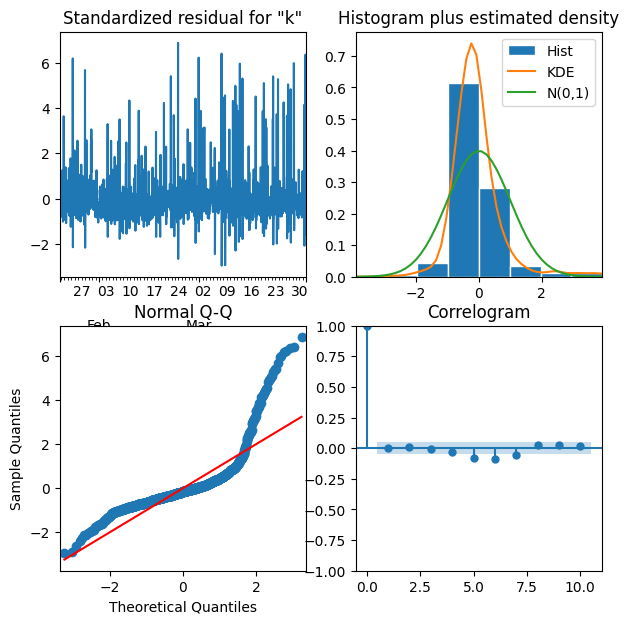

In [8]:
# Residual Check
fig = results.plot_diagnostics(figsize=(7,7))
plt.show()
fig.savefig(f"{c.loc_fig}/SARIMA Diagnostics")

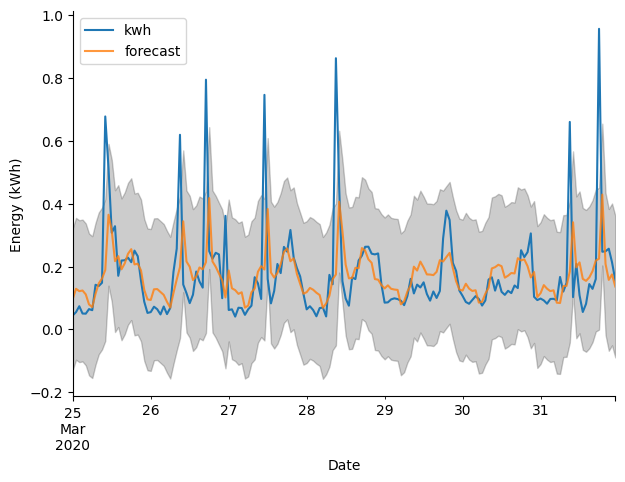

In [9]:
# One step ahead forecast
pred = results.get_prediction(start=pd.to_datetime('25-03-2020'), dynamic=False)
pred_ci = pred.conf_int()

ax = df['25-03-2020':].plot()
# ax = df['2020-03-25':].plot()
# ax.legend(["Observed"])
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.8, figsize=(7, 5))

# Save predictions to output
pred.predicted_mean.to_csv(f"{c.loc_out}/SARIMA_PREDICTIONS.csv")

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
plt.xticks(rotation=0)
ax.set_ylabel('Energy (kWh)')
plt.legend()


fig.savefig(f"{c.loc_fig}/SARIMA Forecasts")
sns.despine()
plt.show()

In [10]:
#expected = df['2020-03-18':]

In [11]:
#Accuracy metrics for the forecast: forecast bias, mean absolute error, mean squared error, and root mean square error
expected = df['2020-03-25':]['kwh']
predictions = pred.predicted_mean
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
bias = sum(forecast_errors) * 1.0/len(expected)
mae = mean_absolute_error(expected, predictions)
mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)

print('Forecast Errors: %s' % forecast_errors)
print('Bias: %f' % bias)
print('MAE: %f' % mae)
print('MSE: %f' % mse)
print('RMSE: %f' % rmse)

Forecast Errors: [-0.052061554645882496, -0.07409810121836893, -0.047851775355995815, -0.07318203362827055, -0.06134724492666267, -0.014871220254530332, -0.009849644037725522, 0.028742298184829623, -0.008369363815790815, -0.013426272270250394, 0.48843230295587964, 0.14829920211299075, -0.006694080296552607, 0.11111021458789982, -0.06251645953867135, 0.027938097278275703, 0.00973771969885967, -0.012255379807945388, -0.041342958559247134, 0.043812940948306595, 0.023793322520784782, -0.03278727078743482, -0.037582217267341345, -0.04309678303610692, -0.03859443954026264, -0.055336974443067, -0.06415879959306837, -0.07147244325806588, -0.036755320795237786, -0.038999660151305134, -0.0012008294754171367, 0.06725879252135189, 0.09787199611946251, 0.42083442112576575, -0.201032726951272, -0.1007312393029998, -0.11562097824029245, -0.04660594044185597, 0.015305986383277737, -0.04459394528694796, -0.058173714410277966, 0.5799683945424464, -0.16866297585582868, 0.008400127656298245, 0.04439375354

In [12]:
df_forecasted = pred.predicted_mean
df_truth = df['2020-03-25':]['kwh']

# Compute the mean square error
mse = ((df_forecasted - df_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 4)))

The Mean Squared Error of our forecasts is 0.0185
The Root Mean Squared Error of our forecasts is 0.1359


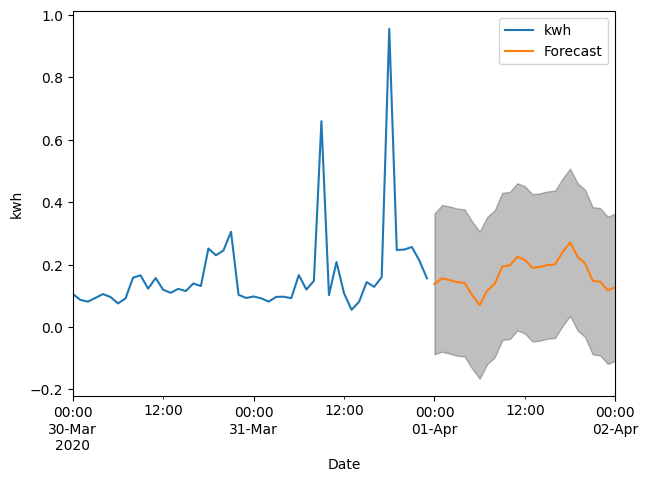

In [13]:
# Steps ahead forecast

pred_uc = results.get_forecast(steps=25)
pred_ci = pred_uc.conf_int()

ax = df['30-03-2020':].plot(label='observed', figsize=(7, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('kwh')

plt.legend()
plt.show()

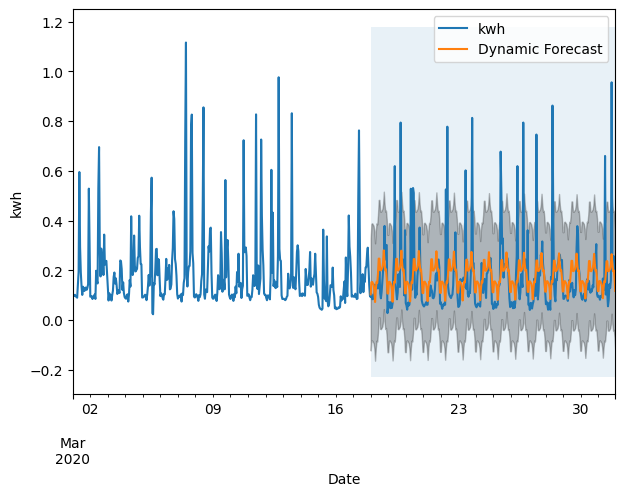

In [14]:
# Dynamic forecast
pred_dynamic = results.get_prediction(start=pd.to_datetime('2020-03-18'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = df['2020-03':].plot(label='observed', figsize=(7, 5))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-03-18'), df.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('kwh')

plt.legend()
plt.show()

In [15]:
# Extract the predicted and true values of our time series
df_forecasted = pred_dynamic.predicted_mean
df_truth = df['2020-03-18':]['kwh']

# Compute the mean square error
mse = ((df_forecasted - df_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 0.02
The Root Mean Squared Error of our forecasts is 0.13
